This notebook will help me understand the data better.

## Basics

In [81]:
# import some packages that I'll need

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

# set color scheme
cpal = ["#f94144","#f3722c","#f8961e","#f9c74f","#90be6d","#43aa8b","#577590"]

# use natural numbers
pd.options.display.float_format = "{:.2f}".format

In [2]:
# load the data

TZA = pd.read_csv('data/Train.csv')

In [3]:
# size of the data set

TZA.shape

(4809, 23)

I'm dealing with a data set of almost 5000 observations and 23 features.
Now I want to understand better what each feature means. Zindi provided a data set with feature explanations.

In [4]:
# find out what features mean

variables = pd.read_csv('data/VariableDefinitions.csv')
variables

,Column Name,Definition
0,id,Unique identifier for each tourist
1,country,The country a tourist coming from.
2,age_group,The age group of a tourist.
3,travel_with,The relation of people a tourist travel with t...
4,total_female,Total number of females
5,total_male,Total number of males
6,purpose,The purpose of visiting Tanzania
7,main_activity,The main activity of tourism in Tanzania
8,infor_source,The source of information about tourism in Tan...
9,tour_arrangment,The arrangment of visiting Tanzania


In [5]:
# find out show how many values are missing (per column)?

missing = pd.DataFrame(TZA.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/TZA.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
travel_with,1114,23.16
total_female,3,0.06
total_male,5,0.10
most_impressing,313,6.51


There are many values missing for the travel_with column, almost one fourth. I'll have to learn more about this column to find out how to deal with these values. First I will check if there's a pattern. I use the missingno package for that.

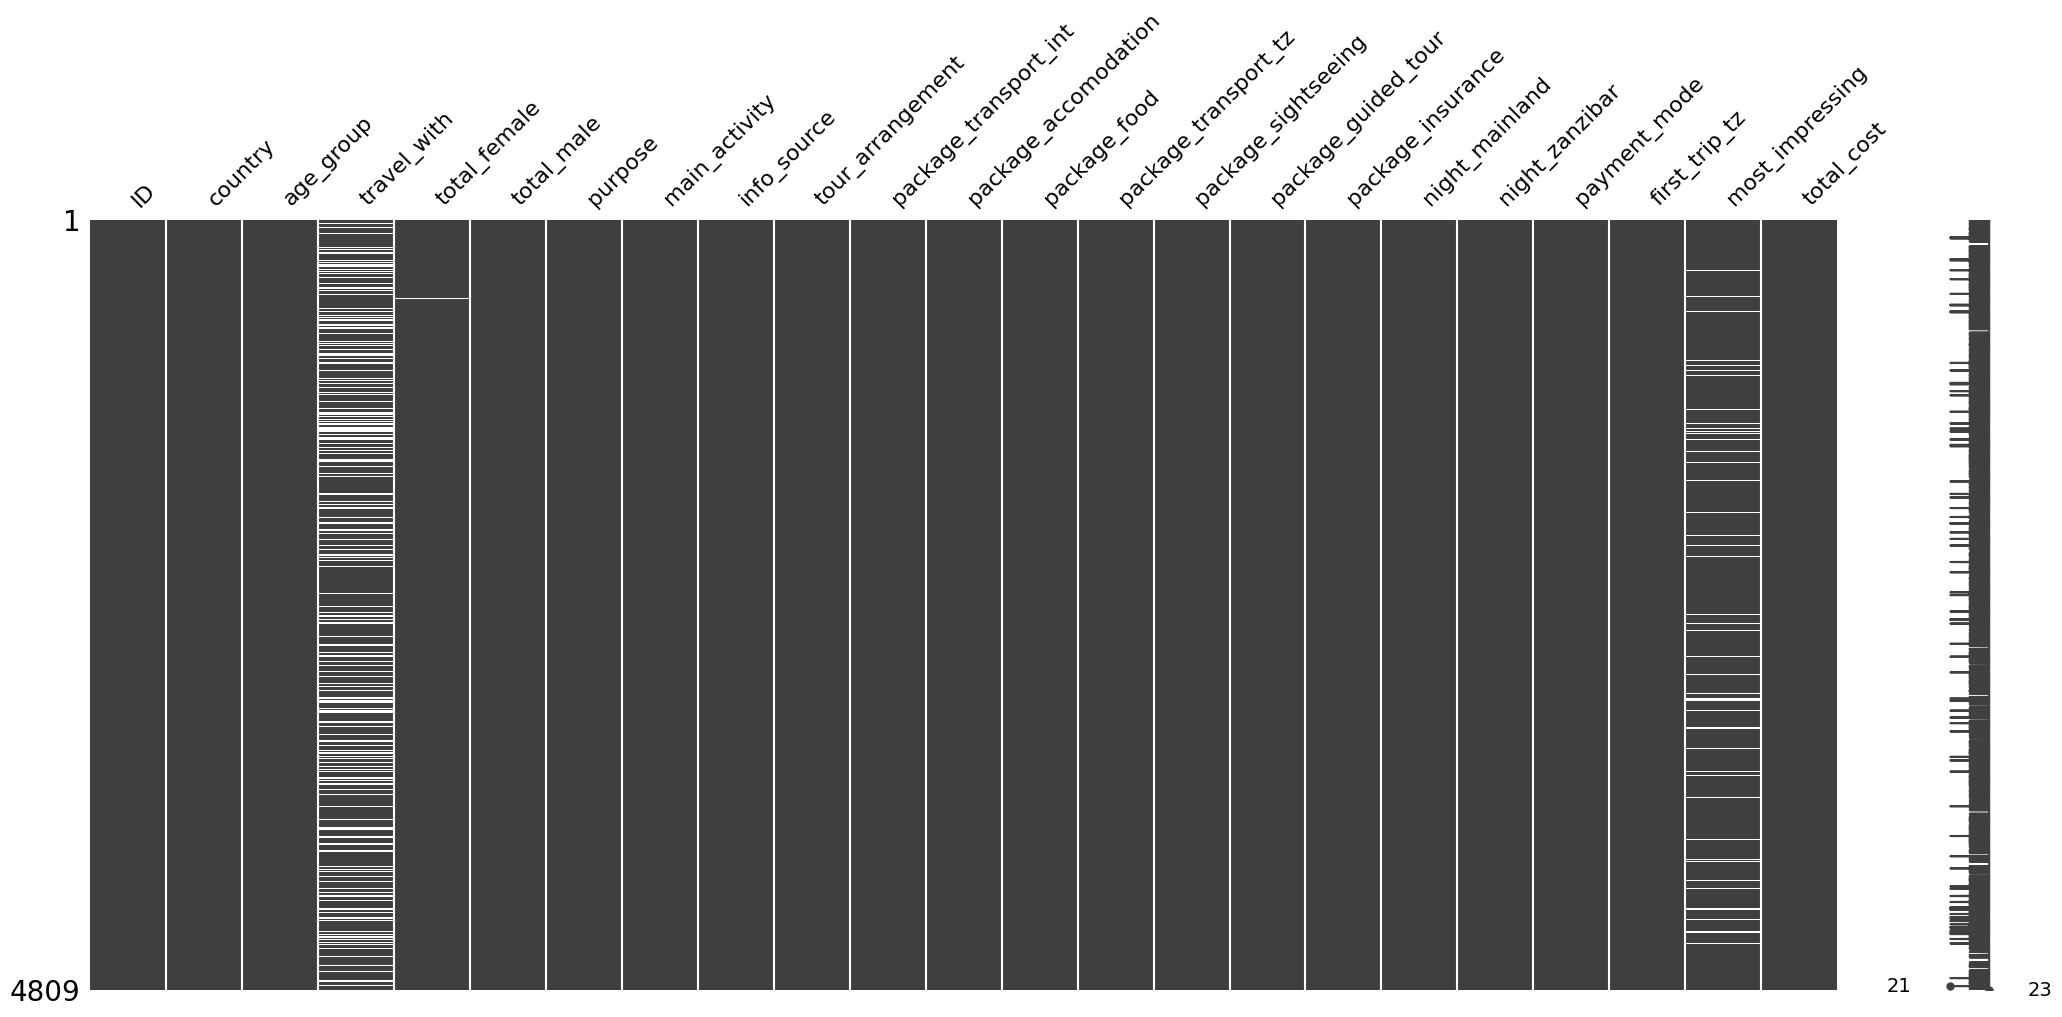

In [6]:
# check for patterns of missing values
import missingno as msno
msno.matrix(TZA);

I can't see an obvious pattern.

In [7]:
# find out which data types I have to deal with
TZA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4809 entries, 0 to 4808
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     4809 non-null   object 
 1   country                4809 non-null   object 
 2   age_group              4809 non-null   object 
 3   travel_with            3695 non-null   object 
 4   total_female           4806 non-null   float64
 5   total_male             4804 non-null   float64
 6   purpose                4809 non-null   object 
 7   main_activity          4809 non-null   object 
 8   info_source            4809 non-null   object 
 9   tour_arrangement       4809 non-null   object 
 10  package_transport_int  4809 non-null   object 
 11  package_accomodation   4809 non-null   object 
 12  package_food           4809 non-null   object 
 13  package_transport_tz   4809 non-null   object 
 14  package_sightseeing    4809 non-null   object 
 15  pack

I have to deal with many categorical features. This can become a bit tricky because I'll need to encode them all later. Let's check how many unique values each of these columns contain.

In [8]:
TZA.nunique()

ID                       4809
country                   105
age_group                   4
travel_with                 5
total_female               14
total_male                 14
purpose                     7
main_activity               9
info_source                 8
tour_arrangement            2
package_transport_int       2
package_accomodation        2
package_food                2
package_transport_tz        2
package_sightseeing         2
package_guided_tour         2
package_insurance           2
night_mainland             64
night_zanzibar             34
payment_mode                4
first_trip_tz               2
most_impressing             7
total_cost               1637
dtype: int64

The number of unique values of IDs is equal to the number of rows, so this already indicates clearly that there are no duplicates in the data set!

There are tourists from 105 different countries, that's lot. (It may be a good idea to group them by regions/continents later.)

There are some columns which are seemlingly intuitive to understand with each a reasonable amount of unique values, further many columns with only 2 unique values (probably yes/no).

The total_female and total_male columns I don't understand yet but I'll have a look at the dataframe now to see how these values actually look in the bigger context.

In [9]:
# have a first look
TZA.head(10)

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,11.0,0.0,Cash,Yes,Friendly People,7790250.0
4,tour_1004,CHINA,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,7.0,4.0,Cash,Yes,No comments,1657500.0
5,tour_1005,UNITED KINGDOM,25-44,NaN,0.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,Yes,Yes,No,9.0,3.0,Cash,Yes,Wildlife,120950.0
6,tour_1007,SOUTH AFRICA,45-64,Alone,0.0,1.0,Business,Mountain climbing,"Friends, relatives",Independent,...,No,No,No,No,9.0,0.0,Cash,Yes,Friendly People,466140.0
7,tour_1008,UNITED STATES OF AMERICA,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,Yes,10.0,3.0,Cash,Yes,Friendly People,3480750.0
8,tour_101,NIGERIA,25-44,Alone,0.0,1.0,Leisure and Holidays,Cultural tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,4.0,0.0,Cash,Yes,NaN,994500.0
9,tour_1011,INDIA,25-44,Alone,1.0,0.0,Business,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,No,5.0,0.0,Credit Card,Yes,Friendly People,2486250.0


Ok, now things make more sense: 

Contrary to my first assumption that there is a single tourist behind each ID, there is apparently a group of tourists behind each ID (or only one tourist when travelling alone).

As expected, many columns simply contain yes/no entries.

The column travel_with, in which so many values are missing, becomes much clearer to me now: Obviously there are simply single travelers behind it. I'll check that now and impute the columns right away (for my EDA only).

I need a new column first which shows the size of travel group, I'll simple add the total_female and total_male.

In [10]:
# add new column with group size
TZA['group_size'] = TZA['total_female'] + TZA['total_male']

In [11]:
TZA.head()

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5,2.0
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,...,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5,1.0
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,...,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0,1.0
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,No,11.0,0.0,Cash,Yes,Friendly People,7790250.0,2.0
4,tour_1004,CHINA,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,...,No,No,No,7.0,4.0,Cash,Yes,No comments,1657500.0,1.0


Now I check whether all travel_with NaNs do have a group size of 1.

In [12]:
# check relation of NaNs and group size

df_NaN = pd.crosstab(TZA['group_size'], TZA['travel_with'].fillna('missing'), normalize='index').mul(100).round(2)
df_NaN.head(50)

travel_with,Alone,Children,Friends/Relatives,Spouse,Spouse and Children,missing
group_size,,,,,,
0.0,26.67,0.00,40.00,13.33,13.33,6.67
1.0,53.10,0.04,0.55,0.55,0.00,45.76
2.0,0.00,5.88,32.34,60.36,0.56,0.87
3.0,0.00,13.46,40.71,2.88,41.67,1.28
4.0,0.38,6.04,33.96,1.13,56.98,1.51
5.0,0.00,5.43,36.96,0.00,56.52,1.09
6.0,0.00,0.00,60.78,0.00,37.25,1.96
7.0,0.00,6.25,56.25,6.25,25.00,6.25
8.0,0.00,8.33,91.67,0.00,0.00,0.00


It seems that my assumption was not bad, but it doesn't cover all cases. For the imputation of the travel_with column I'll rather do the following: If the group size is 1 I'll impute with "alone", if it is bigger than 1 I'll just impute with "missing".

Looking at this also makes me aware of some other issues that I have to have a look at later:
- How can a travel group consist of zero people?
- Is 93 still a reasonable group size?
- How can a group of 4 or 15 be considered an alone traveller?
- How can a group of more than 2 be considered "travelled with spouse"? I understood that this means a couple (of 2) was travelling...

So let's start with some 

## Data Cleaning

First I want to impute the missing values in the travel_with column with "missing"/"Alone".

In [13]:
# fill missing values with "missing"
TZA['travel_with'] = TZA['travel_with'].fillna('missing')

In [14]:
# replace "missing" by "Alone" if group size is 1
TZA.loc[TZA.group_size == 1, 'travel_with'] = 'Alone'

We saw earlier that there are also values missing in the most_impressing column. Let's have a look at the unique values of this column.

In [15]:
# check unique values in most_impressing column
TZA['most_impressing'].unique()

array(['Friendly People', 'Wonderful Country, Landscape, Nature',
       'Excellent Experience', 'No comments', ' Wildlife', nan,
       'Good service', 'Satisfies and Hope Come Back'], dtype=object)

There's already one value "no comments" - I'll also fill the NaN values with this one.

In [16]:
# fill missing values with "No comments"
TZA['most_impressing'] = TZA['most_impressing'].fillna('No comments')

# check again unique values
TZA['most_impressing'].unique()

array(['Friendly People', 'Wonderful Country, Landscape, Nature',
       'Excellent Experience', 'No comments', ' Wildlife', 'Good service',
       'Satisfies and Hope Come Back'], dtype=object)

Now let's check again if the NaNs in travel_with and most_impressing are gone...

In [17]:
missing = pd.DataFrame(TZA.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/TZA.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
total_female,3,0.06
total_male,5,0.10
group_size,8,0.17


They are! That's good. But there are still some values missing in the total_female and total_male columns, and our newly created column group_size also contains NaNs. This was produced by calculating with the other NaNs earlier. So we have to correct that now. 
First let's have a look at the columns with missing total_female and total_male.

In [18]:
TZA[TZA['total_female'].isna()]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size
490,tour_1604,FRANCE,25-44,Friends/Relatives,NaN,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,9.0,5.0,Cash,Yes,No comments,313000.0,NaN
545,tour_1678,ITALY,1-24,Friends/Relatives,NaN,4.0,Volunteering,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,15.0,0.0,Cash,Yes,No comments,9077320.0,NaN
1261,tour_2547,FRANCE,25-44,Friends/Relatives,NaN,1.0,Leisure and Holidays,Wildlife tourism,"Newspaper, magazines,brochures",Package Tour,...,Yes,Yes,Yes,7.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",324300.0,NaN


In [19]:
TZA[TZA['total_male'].isna()]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size
1017,tour_2246,UNITED STATES OF AMERICA,45-64,Friends/Relatives,4.0,NaN,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,No,19.0,0.0,Cash,Yes,No comments,7293000.0,NaN
1473,tour_2810,SPAIN,45-64,Friends/Relatives,7.0,NaN,Other,Hunting tourism,"Travel, agent, tour operator",Package Tour,...,No,No,Yes,11.0,0.0,Cash,No,"Wonderful Country, Landscape, Nature",56960183.0,NaN
2449,tour_3980,SOUTH AFRICA,25-44,Friends/Relatives,0.0,NaN,Meetings and Conference,Wildlife tourism,"Newspaper, magazines,brochures",Independent,...,No,No,No,4.0,0.0,Credit Card,Yes,Friendly People,3978000.0,NaN
2494,tour_4031,FRANCE,25-44,missing,0.0,NaN,Leisure and Holidays,Conference tourism,"Radio, TV, Web",Package Tour,...,Yes,Yes,Yes,6.0,0.0,Cash,Yes,Excellent Experience,4309500.0,NaN
3984,tour_5838,CHINA,25-44,Friends/Relatives,10.0,NaN,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,Yes,4.0,2.0,Cash,Yes,Wildlife,89505000.0,NaN


For lack of other clues, I'll just assume that in these cases NaN equals 0. I'll impute these NaNs accordingly.

In [20]:
# fill missing values with 0
TZA['total_male'] = TZA['total_male'].fillna(0)
TZA['total_female'] = TZA['total_female'].fillna(0)

Now I'll apply the group_size calculation again.

In [21]:
# calculate group size again
TZA['group_size'] = TZA['total_female'] + TZA['total_male']

I also replace once again travel_with by Alone if the group size is 1.

In [22]:
TZA.loc[TZA.group_size == 1, 'travel_with'] = 'Alone'

In [23]:
# check again for missing values 
missing = pd.DataFrame(TZA.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/TZA.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage


Great! No more missing values!

We saw some other irregularities before. There were group sizes of zero. Let's have a look at them.

In [24]:
TZA.loc[TZA['group_size'] == 0]

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost,group_size
170,tour_1205,UNITED STATES OF AMERICA,25-44,Spouse,0.0,0.0,Leisure and Holidays,Wildlife tourism,"Radio, TV, Web",Package Tour,...,No,Yes,No,5.0,4.0,Credit Card,No,Excellent Experience,1657500.0,0.0
705,tour_1867,HUNGARY,45-64,Spouse and Children,0.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,Yes,Yes,No,4.0,0.0,Cash,Yes,Wildlife,7646047.5,0.0
706,tour_1869,UNITED STATES OF AMERICA,45-64,missing,0.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,Yes,Yes,7.0,0.0,Cash,Yes,No comments,21713250.0,0.0
727,tour_1893,UNITED STATES OF AMERICA,45-64,Spouse and Children,0.0,0.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,...,No,No,No,20.0,0.0,Cash,Yes,Friendly People,19227000.0,0.0
1154,tour_2414,GERMANY,45-64,Friends/Relatives,0.0,0.0,Leisure and Holidays,Beach tourism,"Newspaper, magazines,brochures",Package Tour,...,No,No,No,0.0,33.0,Cash,Yes,Wildlife,67399101.0,0.0
1670,tour_3040,ZIMBABWE,1-24,Alone,0.0,0.0,Business,Beach tourism,"Newspaper, magazines,brochures",Independent,...,No,No,No,2.0,0.0,Cash,No,No comments,500000.0,0.0
2243,tour_3730,UNITED STATES OF AMERICA,65+,Spouse,0.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,No,No,14.0,0.0,Cash,Yes,Wildlife,16939650.0,0.0
2335,tour_3840,SPAIN,25-44,Alone,0.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,...,No,Yes,No,4.0,0.0,Cash,Yes,"Wonderful Country, Landscape, Nature",447525.0,0.0
2430,tour_396,AUSTRALIA,1-24,Alone,0.0,0.0,Leisure and Holidays,Hunting tourism,"Travel, agent, tour operator",Independent,...,No,No,No,15.0,5.0,Cash,Yes,Friendly People,11027030.0,0.0
2449,tour_3980,SOUTH AFRICA,25-44,Friends/Relatives,0.0,0.0,Meetings and Conference,Wildlife tourism,"Newspaper, magazines,brochures",Independent,...,No,No,No,4.0,0.0,Credit Card,Yes,Friendly People,3978000.0,0.0


So for these 17 observations we don't have the information how big the travel group was. We can assume that those who travelled "alone" were 1, and those who travelled with "spouse" were 2. 
We don't know for sure, and it's only 17 observations. I'll just remove these rows for my EDA.

In [25]:
# only keep rows with group size greater than 0
TZA = TZA[TZA.group_size > 0]

# check whether 17 rows were deleted
TZA.shape

(4792, 24)

Now I also want to delete all columns, in which the travel_with and group_size columns obviously don't make sense together:
- Alone travellers with group size not equal to 1
- With Spouse travellers with group size not equal to 2

In [26]:
# find the indexes of the rows where the mentioned conditions apply
indexAlone = TZA[ (TZA['group_size'] != 1) & (TZA['travel_with'] == 'Alone') ].index
indexSpouse = TZA[ (TZA['group_size'] != 2) & (TZA['travel_with'] == 'Spouse') ].index

# drop these rows
TZA.drop(indexAlone, inplace=True)
TZA.drop(indexSpouse, inplace=True)

Now have a look again at the crosstab we already used earlier. Do things make more sense now?

In [28]:
df_NaN2 = pd.crosstab(TZA['group_size'], TZA['travel_with'], normalize='index').mul(100).round(2)
df_NaN2.head(50)

travel_with,Alone,Children,Friends/Relatives,Spouse,Spouse and Children,missing
group_size,,,,,,
1.0,100.0,0.00,0.00,0.00,0.00,0.00
2.0,0.0,5.88,32.34,60.36,0.56,0.87
3.0,0.0,13.86,41.91,0.00,42.90,1.32
4.0,0.0,6.08,34.98,0.00,57.41,1.52
5.0,0.0,5.43,36.96,0.00,56.52,1.09
6.0,0.0,0.00,60.78,0.00,37.25,1.96
7.0,0.0,6.25,62.50,0.00,25.00,6.25
8.0,0.0,8.33,91.67,0.00,0.00,0.00
9.0,0.0,0.00,75.00,0.00,12.50,12.50


Yes! We got rid of some values which don't make sense. 

Now it's time to check for obvious outliers. I'll plot boxploxes for the numerical features in my data set. (*not meant to be super beautiful, only for my better understanding"*)

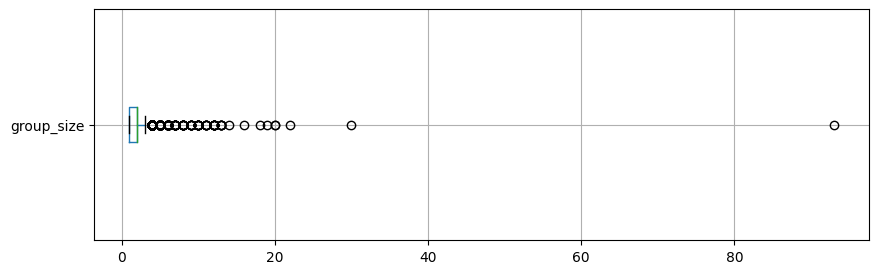

In [76]:
TZA.boxplot(column='group_size', vert=False, figsize= [10,3]);

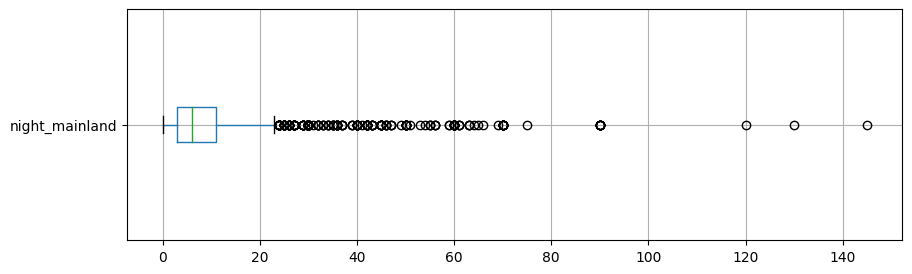

In [59]:
TZA.boxplot(column='night_mainland', vert=False, figsize= [10,3]);

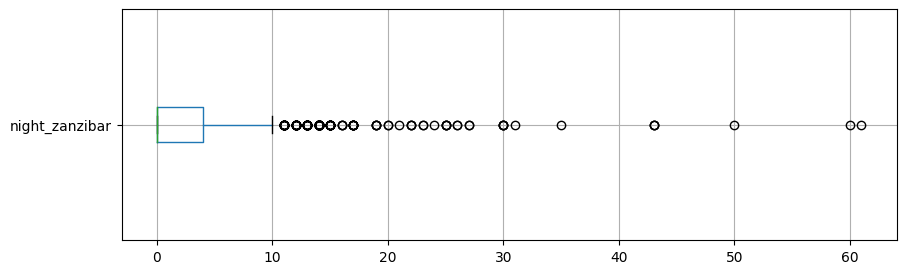

In [60]:
TZA.boxplot(column='night_zanzibar', vert=False, figsize= [10,3]);

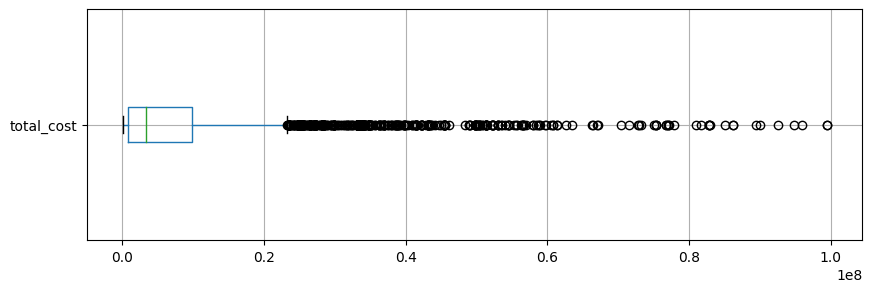

In [80]:
TZA.boxplot(column='total_cost', vert=False, figsize= [10,3]);

I also check the basic statistics:

In [79]:
TZA.describe()

,total_female,total_male,night_mainland,night_zanzibar,total_cost,group_size
count,4776.00,4776.00,4776.00,4776.00,4776.00,4776.00
mean,0.92,1.01,8.50,2.28,8086529.34,1.93
std,1.27,1.14,10.45,4.12,12204420.40,2.07
min,0.00,0.00,0.00,0.00,49000.00,1.00
25%,0.00,1.00,3.00,0.00,794265.50,1.00
50%,1.00,1.00,6.00,0.00,3357182.50,2.00
75%,1.00,1.00,11.00,4.00,9785313.90,2.00
max,49.00,44.00,145.00,61.00,99532875.00,93.00


Is it realistic that a travel group consists of 93? Or that a group spends almost 40.000 € for their holidays? That someone stays almost 5 months on holidays? Not sure, definitely not a *common* behavior, but why not in single cases? I decide to keep the outliers!

Before I start with the EDA I come up with some...

## Hypotheses

- The bigger a group is, the more money they spend.
- The longer a group stays, the more money they spend.
- The more extras a group books, the more money they spend.
- Arranged tours are more expensive than independent tours.
- Tourists from wealthier countries spend more money.
- Older tourists spend more than younger tourists.
- The purpose of the tour has an impact on how much money a group spends.

## EDA

Let's start with exploring the data. First I'll try to find correlations between the numerical features.

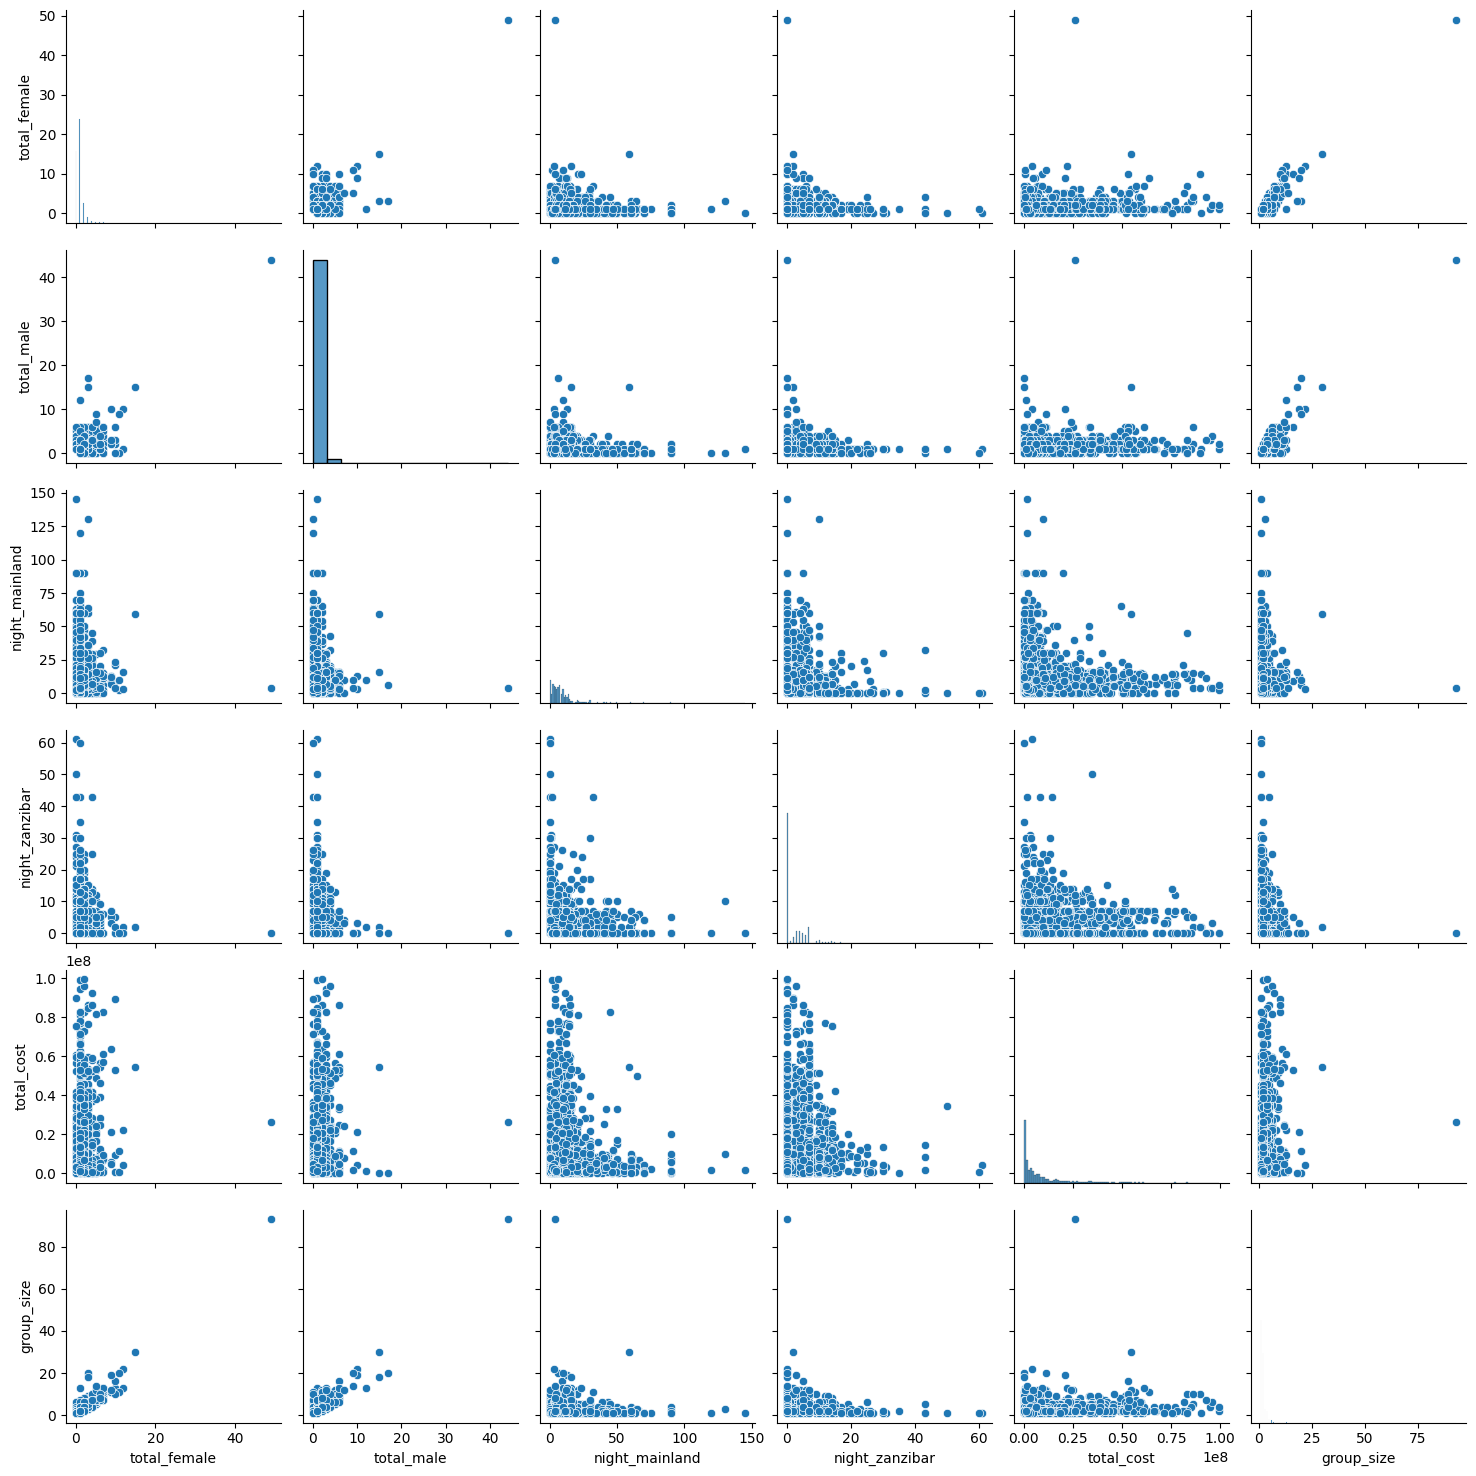

In [85]:
sns.pairplot(data=TZA);